In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision
import torchvision.transforms as transforms
import numpy as np
#from tqdm.auto import tqdm
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def fit_and_plot_powerlaw(x, y, ax=None, plot_kwargs=None, fit_kwargs=None):
    x = np.asarray(x)
    y = np.asarray(y)
    n = x.size

    # 1) do the linear fit in log–log
    logx = np.log(x)
    logy = np.log(y)
    # gamma is slope, log(k) is intercept
    gamma, logk = np.polyfit(logx, logy, 1)
    k = np.exp(logk)

    # 2) compute standard error on gamma
    #   residual variance σ² = SSR / (n−2)
    y_fit = gamma*logx + logk
    resid = logy - y_fit
    ssr = np.sum(resid**2)
    sigma2 = ssr / (n - 2)
    #   Sxx = Σ (logx − mean(logx))²
    Sxx = np.sum((logx - logx.mean())**2)
    stderr_gamma = np.sqrt(sigma2 / Sxx)

    # 3) plotting
    if ax is None:
        ax = plt.gca()
    if plot_kwargs is None:
        plot_kwargs = {}
    if fit_kwargs is None:
        fit_kwargs = {"linestyle":"--", "linewidth":2}

    # raw data
    ax.plot(x, y, label="data", **plot_kwargs)
    # fitted power-law
    ax.plot(x, k * x**gamma, label=f"fit: γ={gamma:.3f}±{stderr_gamma:.3f}", **fit_kwargs)

    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel("P", fontsize=14)
    ax.set_ylabel(r"$\lambda^*$", fontsize=14)
    ax.legend()

    return k, gamma, stderr_gamma



In [4]:
def fit_phi(log_x_grid, mean_val_err_arr, P_arr_fit, min_P, x_left, x_right):
    """
    Fit y ≈ k * x^(-gamma) on each of the mean‐error curves in double‐log space,
    compute per‐curve slope uncertainties, then average the exponents and prefactors.

    Parameters
    ----------
    log_x_grid : array_like, shape (n_x,)
        The x‐axis values for all curves.
    mean_val_err_arr : array_like, shape (n_P, n_x)
        The mean test‐error curves for each P in P_arr_fit.
    P_arr_fit : array_like, shape (n_P,)
        The list of P values corresponding to the rows of mean_val_err_arr.
    x_left : float or None
        Left cutoff on the *normalized* x‐axis; if None, no left cutoff.
    x_right : float or None
        Right cutoff on the *normalized* x‐axis; if None, no right cutoff.

    Returns
    -------
    gamma_1 : float
        Mean fitted exponent γ across all curves.
    k1      : float
        Mean fitted prefactor k across all curves.
    err_gamma_1 : float
        Standard error on the mean exponent (from the per‐curve fit uncertainties).
    """
    gammas = []
    ks      = []
    sigmas  = []

    for i_P, P in enumerate(P_arr_fit):
        y = mean_val_err_arr[i_P+min_P]
        x = log_x_grid

        # find reference point (where train error ~ 0.25)
        idx   = np.nanargmin(y)
        x_ref = x[idx]
        y_ref = y[idx]

        # normalize both axes
        x_norm = x / x_ref
        y_norm = y / y_ref

        # select the fitting window
        mask = np.isfinite(y_norm)
        if x_left is not None:
            mask &= (x_norm >= x_left)
        if x_right is not None:
            mask &= (x_norm <= x_right)
        # also require positive for log
        mask &= (x_norm > 0) & (y_norm > 0)

        xs = x_norm[mask]
        ys = y_norm[mask]
        log_xs = np.log10(xs)
        log_ys = np.log10(ys)

        # linear regression in log-log; returns coeffs [slope, intercept]
        p, cov = np.polyfit(log_xs, log_ys, 1, cov=True)
        slope, intercept = p
        sigma_slope = np.sqrt(cov[0,0])

        # translate to power‐law params
        gamma_i = -slope
        k_i     = 10**intercept

        gammas.append(gamma_i)
        ks.append(k_i)
        sigmas.append(sigma_slope)

        # overlay the fit as a dashed line on your existing plot
        y_fit = k_i * xs**(-gamma_i)
        plt.plot(xs, y_fit, "--", color=colorlist[i_P+min_P])

    gammas = np.array(gammas)
    ks      = np.array(ks)
    sigmas  = np.array(sigmas)

    # mean exponent and prefactor
    gamma_1 = gammas.mean()
    k1      = ks.mean()
    # standard error on the mean exponent
    err_gamma_1 = np.sqrt((sigmas**2/len(sigmas)).sum())

    return gamma_1, k1, err_gamma_1


# CNN

## CNN new version

/tmp/ipykernel_32690/3437122869.py:36: RuntimeWarning: Mean of empty slice
  mean_val_error = np.nanmean(interpolated_val_errors, axis=0)


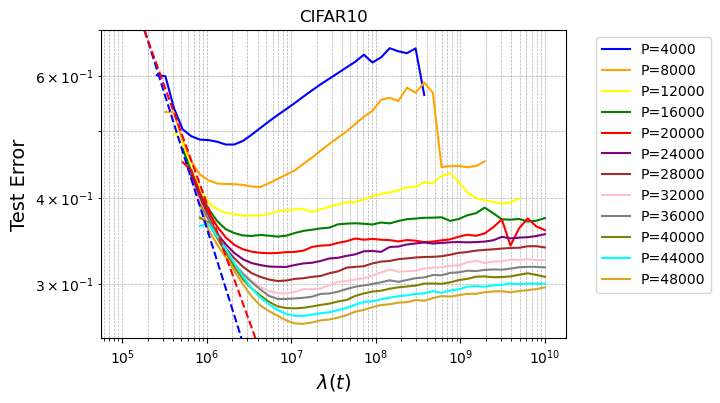

In [5]:
dataset = "CIFAR10"
P_arr = np.arange(4000, 48001, 4000)
seed_arr = np.arange(120,150)

colorlist   = np.array(["blue","orange", "yellow","green","red","purple","brown","pink","grey","olive","cyan","goldenrod","palegreen"])

# Store interpolated results here
mean_curves = {}

# Generate a common log-space grid for interpolation
log_x_grid = np.logspace(5, 10, num=50)  # Adjust range and number of points as needed
mean_val_error_arr = np.ones((len(P_arr), len(log_x_grid)))

to_save = {}
to_save["P_arr"] = P_arr
to_save["seed_arr"] = seed_arr
to_save["log_x_grid"] = log_x_grid

plt.figure(figsize=(6,4))

for i_P, P in enumerate(P_arr):
    interpolated_val_errors = []
    
    for seed in seed_arr:
        logs_saved = np.load(f"../savings/CNN_{dataset}_P{P}_seed{seed}_WD0.0.npy", allow_pickle=True).item()
        model_norm = np.array(logs_saved["model_norm"])
        val_error = np.array(logs_saved["val_error"])*0.01

        # Interpolation: flat in log-scale, thus interpolate on log(x)
        interp_val_error = np.interp(np.log10(log_x_grid), np.log10(model_norm), val_error, left=np.nan, right=np.nan)
        interpolated_val_errors.append(interp_val_error)

    interpolated_val_errors = np.array(interpolated_val_errors)
    
    # Compute mean ignoring NaNs (important if interpolation goes out of original data range)
    mean_val_error = np.nanmean(interpolated_val_errors, axis=0)
    mean_val_error_arr[i_P] = mean_val_error


    # Plot the mean curve
    plt.plot(log_x_grid, mean_val_error, label=f"P={P}", color=colorlist[i_P])


gamma_1_a = 0.39
k1_a = 79.
plt.plot(log_x_grid, k1_a*log_x_grid**-gamma_1_a, "--", color="blue")
gamma_1_b = 0.34
k1_b = 43.
plt.plot(log_x_grid, k1_b*log_x_grid**-gamma_1_b, "--", color="red")
plt.yscale("log")
plt.xscale("log")
plt.xlabel(r"$\lambda(t)$", fontsize=14)
plt.ylabel("Test Error", fontsize=14)
plt.legend(bbox_to_anchor=(1.05,1.0))
plt.title(dataset)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.ylim((0.25,0.7))
plt.show()

/tmp/ipykernel_32690/2028807846.py:29: RuntimeWarning: Mean of empty slice
  mean_val_error = np.nanmean(interpolated_val_errors, axis=0)


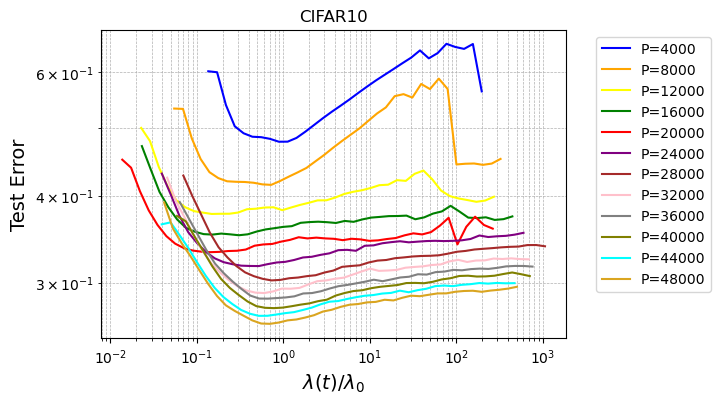

In [6]:
# Store interpolated results here
mean_curves = {}

plt.figure(figsize=(6,4))
l_0_arr = np.zeros(len(P_arr))

for i_P, P in enumerate(P_arr):
    interpolated_val_errors = []
    w_z = 0
    
    for seed in seed_arr:
        logs_saved = np.load(f"../savings/CNN_{dataset}_P{P}_seed{seed}_WD0.0.npy", allow_pickle=True).item()
        model_norm = np.array(logs_saved["model_norm"])
        val_error = np.array(logs_saved["val_error"])*0.01
        train_error =np.array(logs_saved["train_error"])*0.01 

        # Interpolation: flat in log-scale, thus interpolate on log(x)
        interp_val_error = np.interp(np.log10(log_x_grid), np.log10(model_norm), val_error, left=np.nan, right=np.nan)
        interpolated_val_errors.append(interp_val_error)

        idx_zero  = np.argmin((val_error)**2)
        where_zero = model_norm[idx_zero]
        w_z += where_zero/(len(seed_arr))

    interpolated_val_errors = np.array(interpolated_val_errors)
    
    # Compute mean ignoring NaNs (important if interpolation goes out of original data range)
    l_0_arr[i_P] = w_z
    mean_val_error = np.nanmean(interpolated_val_errors, axis=0)
    mean_curves[i_P] = mean_val_error

    # Plot the mean curve
    plt.plot(log_x_grid/w_z, mean_val_error,
             color=colorlist[i_P], label=f"P={P}")
    #plt.plot(log_x_grid, log_x_grid**-0.5, "-.",color="black")
    #plt.plot([w_z,w_z],  np.array([0.05,1.]), "--",
    #         color=colorlist[i_P])
    

plt.yscale("log")
plt.xscale("log")
plt.xlabel(r"$\lambda(t)/\lambda_0$", fontsize=14)
plt.ylabel("Test Error", fontsize=14)
plt.legend(bbox_to_anchor=(1.05,1.0))
plt.title(dataset)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()

/tmp/ipykernel_32690/2068362728.py:28: RuntimeWarning: Mean of empty slice
  mean_val_error = np.nanmean(interpolated_val_errors, axis=0)


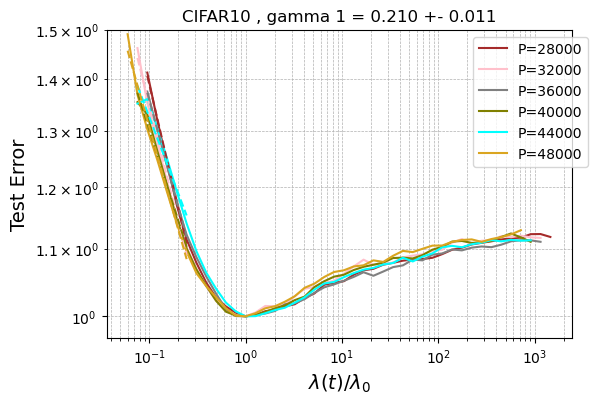

In [7]:
# Store interpolated results here
min_P = 6
P_arr_fit = P_arr[min_P:]

mean_curves = {}

plt.figure(figsize=(6,4))

wd=0.0

for i_P, P in enumerate(P_arr_fit):
    interpolated_val_errors = []
    w_z = 0
    
    for seed in seed_arr:
        logs_saved = np.load(f"../savings/CNN_{dataset}_P{P}_seed{seed}_WD{wd}.npy", allow_pickle=True).item()
        model_norm = np.array(logs_saved["model_norm"])
        val_error = np.array(logs_saved["val_error"])*0.01
        train_error =np.array(logs_saved["train_error"])*0.01 

        # Interpolation: flat in log-scale, thus interpolate on log(x)
        interp_val_error = np.interp(np.log10(log_x_grid), np.log10(model_norm), val_error, left=np.nan, right=np.nan)
        interpolated_val_errors.append(interp_val_error)


    interpolated_val_errors = np.array(interpolated_val_errors)
    
    mean_val_error = np.nanmean(interpolated_val_errors, axis=0)

    idx = np.nanargmin(mean_val_error)
    # Plot the mean curve
    plt.plot(log_x_grid/log_x_grid[idx], mean_val_error/mean_val_error[idx],
             color=colorlist[i_P+min_P], label=f"P={P}")
    #plt.plot(log_x_grid, log_x_grid**-0.5, "-.",color="black")
    #plt.plot([w_z,w_z],  np.array([0.05,1.]), "--",
    #         color=colorlist[i_P])

    #gamma_1 = 0.23
    #k1 = 0.8
    #plt.plot(log_x_grid/log_x_grid[idx], k1*(log_x_grid/log_x_grid[idx])**-gamma_1, "--",
    #         color="black")

x_left = None
x_right = 3e-1
gamma_1, k1, err_gamma_1 = fit_phi(log_x_grid, mean_val_error_arr, P_arr_fit, min_P, x_left, x_right)

plt.yscale("log")
plt.xscale("log")
plt.xlabel(r"$\lambda(t)/\lambda_0$", fontsize=14)
plt.ylabel("Test Error", fontsize=14)
plt.legend(bbox_to_anchor=(1.05,1.0))
plt.title("{} , gamma 1 = {:.3f} +- {:.3f}".format(dataset, gamma_1, err_gamma_1))
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.ylim((0.97,1.5))
plt.show()

In [8]:
factor = 1

Fitted power law: k2 = 13.48, gamma2 = 1.321


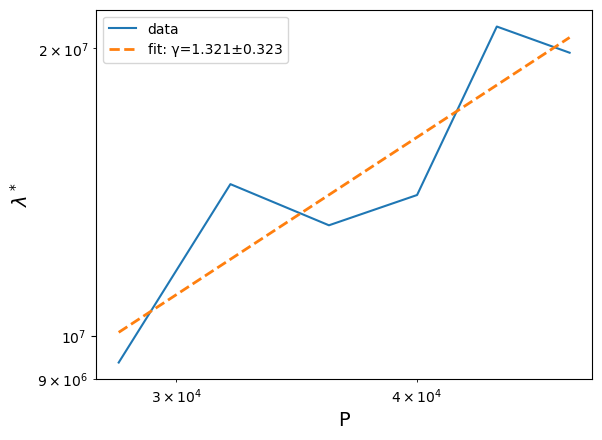

In [9]:
l_power_law = factor*l_0_arr[min_P:]
k2, gamma_2, err_gamma_2 = fit_and_plot_powerlaw(P_arr_fit, l_power_law)
print(f"Fitted power law: k2 = {k2:.4g}, gamma2 = {gamma_2:.4g}")

In [ ]:
'''
l_power_law = factor * l_0_arr

k2, gamma_2 = fit_and_plot_powerlaw_offset(P_arr, l_power_law, C2)
print(f"Offset power law fit: k={k2:.4g}, γ={gamma_2:.4g}, C={C2:.4g}")
'''

In [10]:
print(gamma_1*gamma_2)

0.2769494430564887


/tmp/ipykernel_32690/3413053508.py:20: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


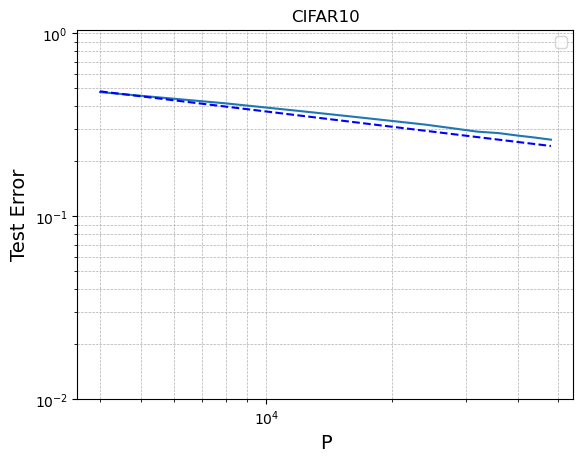

In [11]:
eps_lam_star_P_arr = np.zeros(len(P_arr))

lambda_star_arr = np.zeros(len(P_arr))

for i_P,P in enumerate(P_arr):
     idx = np.nanargmin(mean_val_error_arr[i_P])
     #idx = ((log_x_grid-l_power_law[i_P])**2) 
     eps_lam_star_P_arr[i_P] = mean_val_error_arr[i_P,idx]
     lambda_star_arr[i_P] = log_x_grid[idx]

plt.plot(P_arr, eps_lam_star_P_arr)

plt.plot(P_arr, 10*k1*(k2*P_arr**gamma_2)**-gamma_1, "--", color="blue")
#plt.plot(P_arr, 3.6*P_arr**-0.24, "--", color="red")

plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"P", fontsize=14)
plt.ylabel("Test Error", fontsize=14)
plt.legend()
plt.title(dataset)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)

plt.ylim((1e-2,1.05))
plt.show()

In [13]:
name_save = "CNN_CIFAR10"

to_save["mean_val_error_arr"] = mean_val_error_arr
to_save["eps_lam_star_P_arr"] = eps_lam_star_P_arr
to_save["lambda_star_arr"] = lambda_star_arr
to_save["k1"] = k1
to_save["gamma_1"] = gamma_1
to_save["err_gamma_1"] = err_gamma_1
to_save["k2"] = k2
to_save["gamma_2"] = gamma_2
to_save["err_gamma_2"] = err_gamma_2

to_save["factor"] = factor
to_save["l_0_arr"] = l_0_arr
to_save["min_P"] = min_P

np.save(name_save, to_save)

## CIFAR100

/tmp/ipykernel_5204/2784244405.py:36: RuntimeWarning: Mean of empty slice
  mean_val_error = np.nanmean(interpolated_val_errors, axis=0)


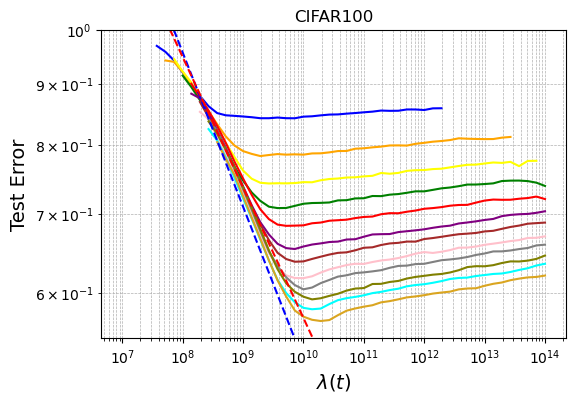

In [291]:
dataset = "CIFAR100"
P_arr = np.arange(4000, 48001, 4000)
seed_arr = np.arange(120,138)

colorlist   = np.array(["blue","orange", "yellow","green","red","purple","brown","pink","grey","olive","cyan","goldenrod","palegreen"])

# Store interpolated results here
mean_curves = {}

# Generate a common log-space grid for interpolation
log_x_grid = np.logspace(7, 14, num=50)  # Adjust range and number of points as needed
mean_val_error_arr = np.zeros((len(P_arr), len(log_x_grid)))

to_save = {}
to_save["P_arr"] = P_arr
to_save["seed_arr"] = seed_arr
to_save["log_x_grid"] = log_x_grid

plt.figure(figsize=(6,4))

for i_P, P in enumerate(P_arr):
    interpolated_val_errors = []
    
    for seed in seed_arr:
        logs_saved = np.load(f"../savings/CNN_{dataset}_P{P}_seed{seed}_WD0.0.npy", allow_pickle=True).item()
        model_norm = np.array(logs_saved["model_norm"])
        val_error = np.array(logs_saved["val_error"])*0.01

        # Interpolation: flat in log-scale, thus interpolate on log(x)
        interp_val_error = np.interp(np.log10(log_x_grid), np.log10(model_norm), val_error, left=np.nan, right=np.nan)
        interpolated_val_errors.append(interp_val_error)

    interpolated_val_errors = np.array(interpolated_val_errors)
    
    # Compute mean ignoring NaNs (important if interpolation goes out of original data range)
    mean_val_error = np.nanmean(interpolated_val_errors, axis=0)
    mean_val_error_arr[i_P] = mean_val_error

    # Plot the mean curve
    plt.plot(log_x_grid, mean_val_error, label=f"P={P}", color=colorlist[i_P])




gamma_1_a = 0.13
k1_a = 10.5
plt.plot(log_x_grid, k1_a*log_x_grid**-gamma_1_a, "--", color="blue")
gamma_1_b = 0.11
k1_b = 7.2
plt.plot(log_x_grid, k1_b*log_x_grid**-gamma_1_b, "--", color="red")
plt.yscale("log")
plt.xscale("log")
plt.xlabel(r"$\lambda(t)$", fontsize=14)
plt.ylabel("Test Error", fontsize=14)
#plt.legend()
plt.title(dataset)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.ylim((0.55,1.))
plt.show()

In [292]:
C2= 4e8

/tmp/ipykernel_5204/3397722838.py:30: RuntimeWarning: Mean of empty slice
  mean_val_error = np.nanmean(interpolated_val_errors, axis=0)


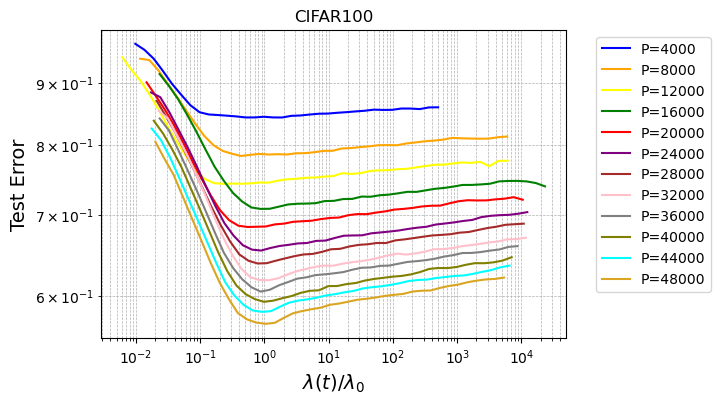

In [293]:
# Store interpolated results here
mean_curves = {}


plt.figure(figsize=(6,4))
l_0_arr = np.zeros(len(P_arr))

for i_P, P in enumerate(P_arr):
    interpolated_val_errors = []
    w_z = 0
    
    for seed in seed_arr:
        logs_saved = np.load(f"../savings/CNN_{dataset}_P{P}_seed{seed}_WD0.0.npy", allow_pickle=True).item()
        model_norm = np.array(logs_saved["model_norm"])
        val_error = np.array(logs_saved["val_error"])*0.01
        train_error =np.array(logs_saved["train_error"])*0.01 

        # Interpolation: flat in log-scale, thus interpolate on log(x)
        interp_val_error = np.interp(np.log10(log_x_grid), np.log10(model_norm), val_error, left=np.nan, right=np.nan)
        interpolated_val_errors.append(interp_val_error)

        idx_zero  = np.argmin((val_error)**2)
        where_zero = model_norm[idx_zero]
        w_z += where_zero/(len(seed_arr))

    interpolated_val_errors = np.array(interpolated_val_errors)
    
    # Compute mean ignoring NaNs (important if interpolation goes out of original data range)
    l_0_arr[i_P] = w_z
    mean_val_error = np.nanmean(interpolated_val_errors, axis=0)
    mean_curves[i_P] = mean_val_error

    # Plot the mean curve
    plt.plot(log_x_grid/w_z, mean_val_error,
             color=colorlist[i_P], label=f"P={P}")
    #plt.plot(log_x_grid, log_x_grid**-0.5, "-.",color="black")
    #plt.plot([w_z,w_z],  np.array([0.05,1.]), "--",
    #         color=colorlist[i_P])
    

plt.yscale("log")
plt.xscale("log")
plt.xlabel(r"$\lambda(t)/\lambda_0$", fontsize=14)
plt.ylabel("Test Error", fontsize=14)
plt.legend(bbox_to_anchor=(1.05,1.0))
plt.title(dataset)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()

/tmp/ipykernel_5204/2068362728.py:28: RuntimeWarning: Mean of empty slice
  mean_val_error = np.nanmean(interpolated_val_errors, axis=0)


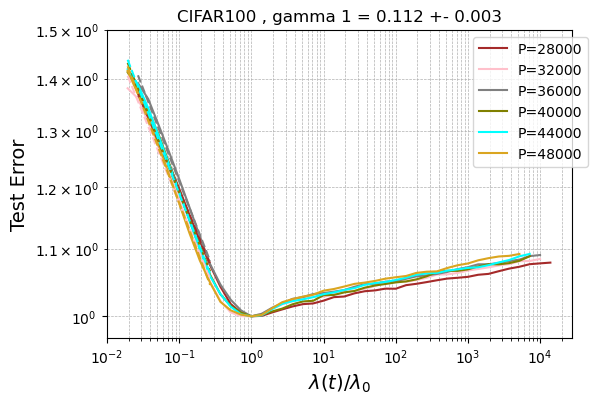

In [294]:
# Store interpolated results here
min_P = 6
P_arr_fit = P_arr[min_P:]

mean_curves = {}

plt.figure(figsize=(6,4))

wd=0.0

for i_P, P in enumerate(P_arr_fit):
    interpolated_val_errors = []
    w_z = 0
    
    for seed in seed_arr:
        logs_saved = np.load(f"../savings/CNN_{dataset}_P{P}_seed{seed}_WD{wd}.npy", allow_pickle=True).item()
        model_norm = np.array(logs_saved["model_norm"])
        val_error = np.array(logs_saved["val_error"])*0.01
        train_error =np.array(logs_saved["train_error"])*0.01 

        # Interpolation: flat in log-scale, thus interpolate on log(x)
        interp_val_error = np.interp(np.log10(log_x_grid), np.log10(model_norm), val_error, left=np.nan, right=np.nan)
        interpolated_val_errors.append(interp_val_error)


    interpolated_val_errors = np.array(interpolated_val_errors)
    
    mean_val_error = np.nanmean(interpolated_val_errors, axis=0)

    idx = np.nanargmin(mean_val_error)
    # Plot the mean curve
    plt.plot(log_x_grid/log_x_grid[idx], mean_val_error/mean_val_error[idx],
             color=colorlist[i_P+min_P], label=f"P={P}")
    #plt.plot(log_x_grid, log_x_grid**-0.5, "-.",color="black")
    #plt.plot([w_z,w_z],  np.array([0.05,1.]), "--",
    #         color=colorlist[i_P])

    #gamma_1 = 0.23
    #k1 = 0.8
    #plt.plot(log_x_grid/log_x_grid[idx], k1*(log_x_grid/log_x_grid[idx])**-gamma_1, "--",
    #         color="black")

x_left = None
x_right = 3e-1
gamma_1, k1, err_gamma_1 = fit_phi(log_x_grid, mean_val_error_arr, P_arr_fit, min_P, x_left, x_right)

plt.yscale("log")
plt.xscale("log")
plt.xlabel(r"$\lambda(t)/\lambda_0$", fontsize=14)
plt.ylabel("Test Error", fontsize=14)
plt.legend(bbox_to_anchor=(1.05,1.0))
plt.title("{} , gamma 1 = {:.3f} +- {:.3f}".format(dataset, gamma_1, err_gamma_1))
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.ylim((0.97,1.5))
plt.show()

In [295]:
factor = 1.

Fitted power law: k2 = 3066, gamma2 = 1.445


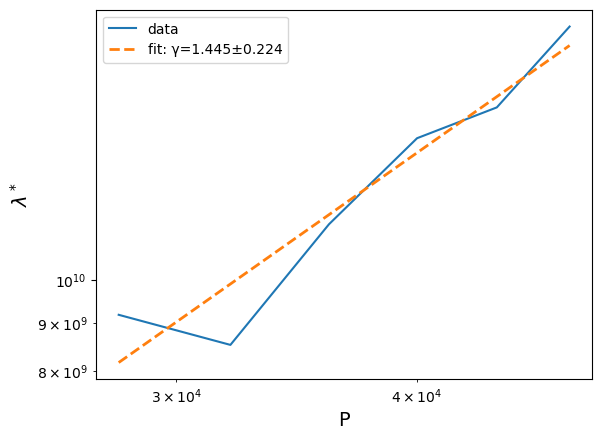

In [296]:
l_power_law = factor*l_0_arr[min_P:]
k2, gamma_2,err_gamma_2  = fit_and_plot_powerlaw(P_arr_fit, l_power_law)
print(f"Fitted power law: k2 = {k2:.4g}, gamma2 = {gamma_2:.4g}")

In [ ]:
'''
k2, gamma_2 = fit_and_plot_powerlaw_offset(P_arr, l_power_law, C2)
print(f"Offset power law fit: k={k2:.4g}, γ={gamma_2:.4g}, C={C2:.4g}")
'''

In [ ]:
gamma_1 = (gamma_1_a+gamma_1_b)/2
k1 = (k1_a+k1_b)/2
print(gamma_1*gamma_2)

/tmp/ipykernel_5204/502517652.py:20: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


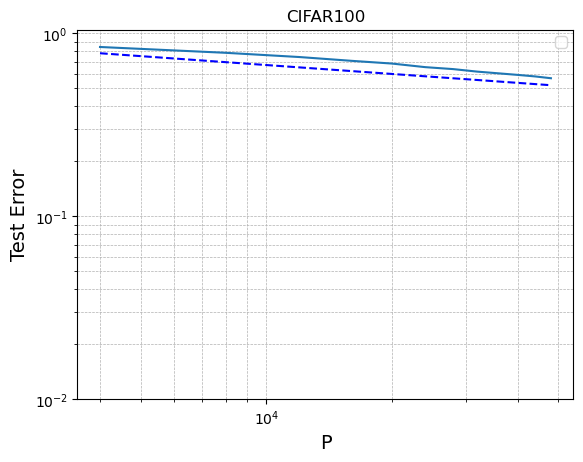

In [297]:
eps_lam_star_P_arr = np.zeros(len(P_arr))

lambda_star_arr = np.zeros(len(P_arr))

for i_P,P in enumerate(P_arr):
     idx = np.nanargmin(mean_val_error_arr[i_P])
     #idx = ((log_x_grid-l_power_law[i_P])**2) 
     eps_lam_star_P_arr[i_P] = mean_val_error_arr[i_P,idx]
     lambda_star_arr[i_P] = log_x_grid[idx]

plt.plot(P_arr, eps_lam_star_P_arr)

plt.plot(P_arr, 8*k1*(k2*P_arr**gamma_2)**-gamma_1, "--", color="blue")
#plt.plot(P_arr, 3.6*P_arr**-0.24, "--", color="red")

plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"P", fontsize=14)
plt.ylabel("Test Error", fontsize=14)
plt.legend()
plt.title(dataset)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.ylim((1e-2,1.05))
plt.show()

In [298]:
name_save = "CNN_CIFAR100"

to_save["mean_val_error_arr"] = mean_val_error_arr
to_save["eps_lam_star_P_arr"] = eps_lam_star_P_arr
to_save["lambda_star_arr"] = lambda_star_arr
to_save["k1"] = k1
to_save["gamma_1"] = gamma_1
to_save["err_gamma_1"] = err_gamma_1
to_save["k2"] = k2
to_save["gamma_2"] = gamma_2
to_save["err_gamma_2"] = err_gamma_2
to_save["C2"] = C2
to_save["factor"] = factor
to_save["l_0_arr"] = l_0_arr
to_save["min_P"] = min_P

np.save(name_save, to_save)

# ResNet

## CIFAR10

/tmp/ipykernel_5204/3609420767.py:37: RuntimeWarning: Mean of empty slice
  mean_val_error = np.nanmean(interpolated_val_errors, axis=0)


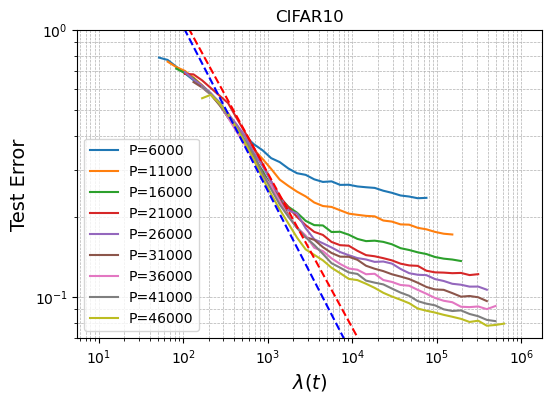

In [312]:
dataset = "CIFAR10"
P_arr = np.arange(6000, 46001, 5000)
seed_arr = np.arange(1120,1130)

wd=0.0
colorlist   = np.array(["blue","orange", "yellow","green","red","purple","brown","pink","grey","olive","cyan","goldenrod","palegreen"])

# Store interpolated results here
mean_curves = {}

# Generate a common log-space grid for interpolation
log_x_grid = np.logspace(1, 6, num=50)  # Adjust range and number of points as needed
mean_val_error_arr = np.zeros((len(P_arr), len(log_x_grid)))

to_save = {}
to_save["P_arr"] = P_arr
to_save["seed_arr"] = seed_arr
to_save["log_x_grid"] = log_x_grid

plt.figure(figsize=(6,4))

for i_P,P in enumerate(P_arr):
    interpolated_val_errors = []
    
    for seed in seed_arr:
        logs_saved = np.load(f"../savings/ResNet_{dataset}_P{P}_seed{seed}_WD{wd}.npy", allow_pickle=True).item()
        model_norm = np.array(logs_saved["model_norm"])
        val_error = np.array(logs_saved["val_error"])*0.01

        # Interpolation: flat in log-scale, thus interpolate on log(x)
        interp_val_error = np.interp(np.log10(log_x_grid), np.log10(model_norm), val_error, left=np.nan, right=np.nan)
        interpolated_val_errors.append(interp_val_error)

    interpolated_val_errors = np.array(interpolated_val_errors)
    
    # Compute mean ignoring NaNs (important if interpolation goes out of original data range)
    mean_val_error = np.nanmean(interpolated_val_errors, axis=0)
    mean_curves[P] = mean_val_error
    mean_val_error_arr[i_P] = mean_val_error


    # Plot the mean curve
    plt.plot(log_x_grid, mean_val_error, label=f"P={P}")

gamma_1_a = 0.615
k1_a = 17.5
plt.plot(log_x_grid, k1_a*log_x_grid**-gamma_1_a, "--", color="blue")
gamma_1_b = 0.58
k1_b = 16.
plt.plot(log_x_grid, k1_b*log_x_grid**-gamma_1_b, "--", color="red")
plt.yscale("log")
plt.xscale("log")
plt.xlabel(r"$\lambda(t)$", fontsize=14)
plt.ylabel("Test Error", fontsize=14)
plt.legend()
plt.title(dataset)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)

plt.ylim((0.07,1.))
plt.show()

/tmp/ipykernel_5204/487029141.py:31: RuntimeWarning: Mean of empty slice
  mean_val_error = np.nanmean(interpolated_val_errors, axis=0)


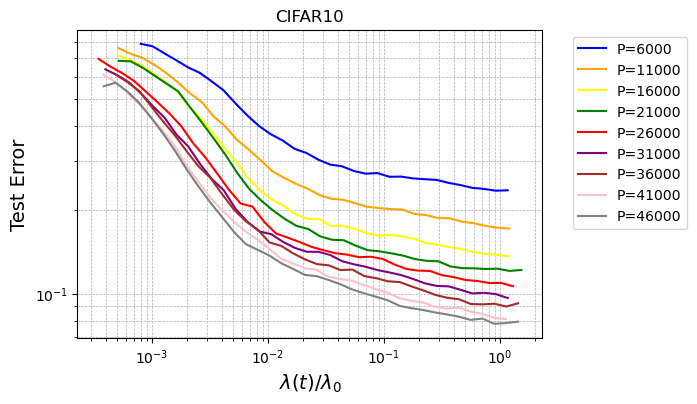

In [315]:
# Store interpolated results here
mean_curves = {}

# Generate a common log-space grid for interpolation

plt.figure(figsize=(6,4))
l_0_arr = np.zeros(len(P_arr))

for i_P, P in enumerate(P_arr):
    interpolated_val_errors = []
    w_z = 0
    
    for seed in seed_arr:
        logs_saved = np.load(f"../savings/ResNet_{dataset}_P{P}_seed{seed}_WD{wd}.npy", allow_pickle=True).item()
        model_norm = np.array(logs_saved["model_norm"])
        val_error = np.array(logs_saved["val_error"])*0.01
        train_error =np.array(logs_saved["train_error"])*0.01 

        # Interpolation: flat in log-scale, thus interpolate on log(x)
        interp_val_error = np.interp(np.log10(log_x_grid), np.log10(model_norm), val_error, left=np.nan, right=np.nan)
        interpolated_val_errors.append(interp_val_error)

        idx_zero  = np.argmin((val_error)**2)
        where_zero = model_norm[idx_zero]
        w_z += where_zero/(len(seed_arr))

    interpolated_val_errors = np.array(interpolated_val_errors)
    
    # Compute mean ignoring NaNs (important if interpolation goes out of original data range)
    l_0_arr[i_P] = w_z
    mean_val_error = np.nanmean(interpolated_val_errors, axis=0)
    mean_curves[i_P] = mean_val_error

    # Plot the mean curve
    plt.plot(log_x_grid/w_z, mean_val_error,
             color=colorlist[i_P], label=f"P={P}")
    #plt.plot(log_x_grid, log_x_grid**-0.5, "-.",color="black")
    #plt.plot([w_z,w_z],  np.array([0.05,1.]), "--",
    #         color=colorlist[i_P])
    

plt.yscale("log")
plt.xscale("log")
plt.xlabel(r"$\lambda(t)/\lambda_0$", fontsize=14)
plt.ylabel("Test Error", fontsize=14)
plt.legend(bbox_to_anchor=(1.05,1.0))
plt.title(dataset)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()

/tmp/ipykernel_5204/1422545208.py:28: RuntimeWarning: Mean of empty slice
  mean_val_error = np.nanmean(interpolated_val_errors, axis=0)


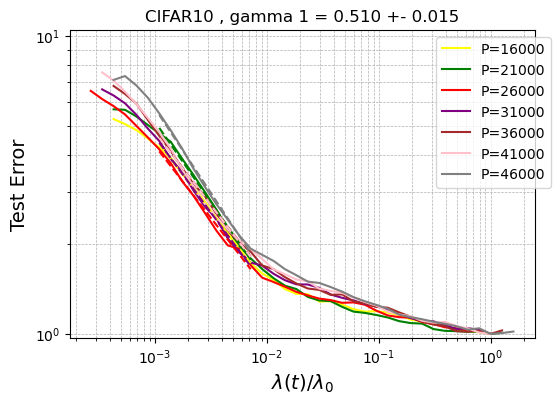

In [317]:
# Store interpolated results here
min_P = 2
P_arr_fit = P_arr[min_P:]

mean_curves = {}

plt.figure(figsize=(6,4))

wd=0.0

for i_P, P in enumerate(P_arr_fit):
    interpolated_val_errors = []
    w_z = 0
    
    for seed in seed_arr:
        logs_saved = np.load(f"../savings/ResNet_{dataset}_P{P}_seed{seed}_WD{wd}.npy", allow_pickle=True).item()
        model_norm = np.array(logs_saved["model_norm"])
        val_error = np.array(logs_saved["val_error"])*0.01
        train_error =np.array(logs_saved["train_error"])*0.01 

        # Interpolation: flat in log-scale, thus interpolate on log(x)
        interp_val_error = np.interp(np.log10(log_x_grid), np.log10(model_norm), val_error, left=np.nan, right=np.nan)
        interpolated_val_errors.append(interp_val_error)


    interpolated_val_errors = np.array(interpolated_val_errors)
    
    mean_val_error = np.nanmean(interpolated_val_errors, axis=0)

    idx = np.nanargmin(mean_val_error)
    # Plot the mean curve
    plt.plot(log_x_grid/log_x_grid[idx], mean_val_error/mean_val_error[idx],
             color=colorlist[i_P+min_P], label=f"P={P}")
    #plt.plot(log_x_grid, log_x_grid**-0.5, "-.",color="black")
    #plt.plot([w_z,w_z],  np.array([0.05,1.]), "--",
    #         color=colorlist[i_P])

    #gamma_1 = 0.23
    #k1 = 0.8
    #plt.plot(log_x_grid/log_x_grid[idx], k1*(log_x_grid/log_x_grid[idx])**-gamma_1, "--",
    #         color="black")

x_left = 1e-3
x_right = 9e-3
gamma_1, k1, err_gamma_1 = fit_phi(log_x_grid, mean_val_error_arr, P_arr_fit, min_P, x_left, x_right)

plt.yscale("log")
plt.xscale("log")
plt.xlabel(r"$\lambda(t)/\lambda_0$", fontsize=14)
plt.ylabel("Test Error", fontsize=14)
plt.legend(bbox_to_anchor=(1.05,1.0))
plt.title("{} , gamma 1 = {:.3f} +- {:.3f}".format(dataset, gamma_1, err_gamma_1))
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.ylim((0.97,10.5))
plt.show()

In [318]:
factor = 1.

Fitted power law: k2 = 13.06, gamma2 = 0.9763


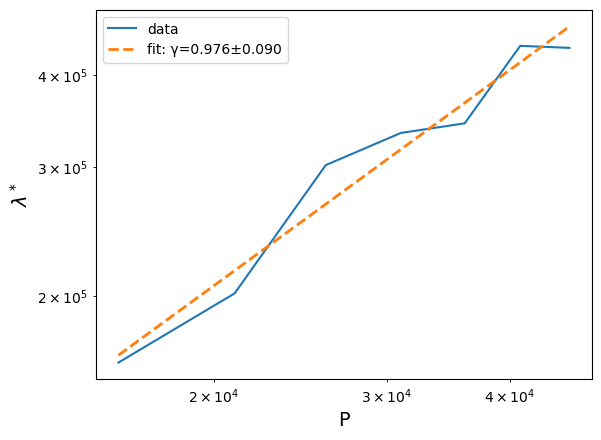

In [320]:
l_power_law = factor*l_0_arr[min_P:]
k2, gamma_2,err_gamma_2 = fit_and_plot_powerlaw(P_arr_fit, l_power_law)
print(f"Fitted power law: k2 = {k2:.4g}, gamma2 = {gamma_2:.4g}")

In [ ]:
'''
l_power_law = factor * l_0_arr

k2, gamma_2 = fit_and_plot_powerlaw_offset(P_arr, l_power_law, C2)
print(f"Offset power law fit: k={k2:.4g}, γ={gamma_2:.4g}, C={C2:.4g}")
'''

In [ ]:
gamma_1 = (gamma_1_a+gamma_1_b)/2
k1 = (k1_a+k1_b)/2
print(gamma_1*gamma_2)

/tmp/ipykernel_5204/2069843730.py:20: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


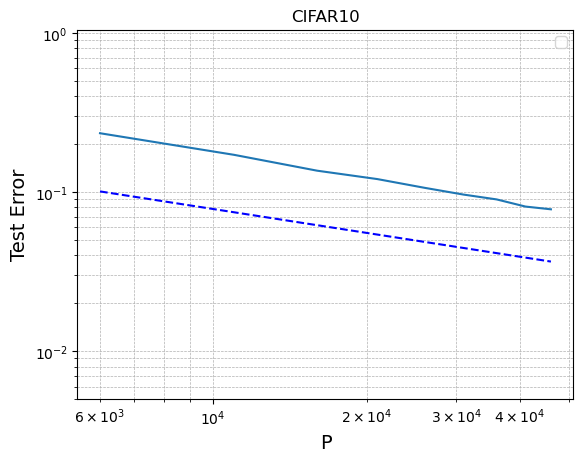

In [321]:
eps_lam_star_P_arr = np.zeros(len(P_arr))

lambda_star_arr = np.zeros(len(P_arr))

for i_P,P in enumerate(P_arr):
     idx = np.nanargmin(mean_val_error_arr[i_P])
     #idx = ((log_x_grid-l_power_law[i_P])**2) 
     eps_lam_star_P_arr[i_P] = mean_val_error_arr[i_P,idx]
     lambda_star_arr[i_P] = log_x_grid[idx]

plt.plot(P_arr, eps_lam_star_P_arr)

plt.plot(P_arr,  200*k1*(k2*P_arr**gamma_2)**-gamma_1, "--", color="blue")
#plt.plot(P_arr, 3.6*P_arr**-0.24, "--", color="red")

plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"P", fontsize=14)
plt.ylabel("Test Error", fontsize=14)
plt.legend()
plt.title(dataset)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.ylim((5e-3,1.05))
plt.show()

In [322]:
name_save = "ResNet_CIFAR10"

to_save["mean_val_error_arr"] = mean_val_error_arr
to_save["eps_lam_star_P_arr"] = eps_lam_star_P_arr
to_save["lambda_star_arr"] = lambda_star_arr
to_save["k1"] = k1
to_save["gamma_1"] = gamma_1
to_save["err_gamma_1"] = err_gamma_1
to_save["k2"] = k2
to_save["gamma_2"] = gamma_2
to_save["err_gamma_2"] = err_gamma_2
to_save["C2"] = C2
to_save["factor"] = factor
to_save["l_0_arr"] = l_0_arr
to_save["min_P"] = min_P

np.save(name_save, to_save)

## CIFAR100

/tmp/ipykernel_5204/3011593662.py:36: RuntimeWarning: Mean of empty slice
  mean_val_error = np.nanmean(interpolated_val_errors, axis=0)


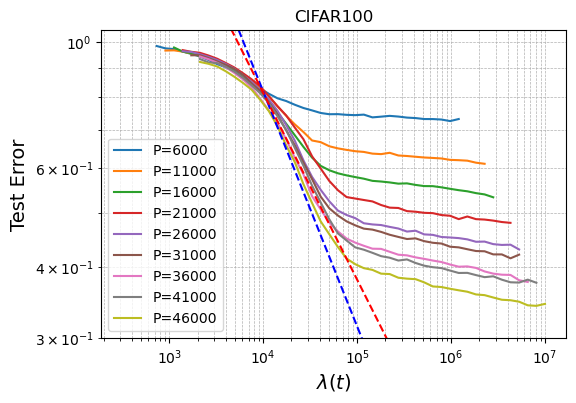

In [330]:
dataset = "CIFAR100"
P_arr = np.arange(6000, 46001, 5000)
seed_arr = np.arange(1120,1126) 

# Store interpolated results here
mean_curves = {}
mean_val_error_arr = np.zeros((len(P_arr), len(log_x_grid)))


# Generate a common log-space grid for interpolation
log_x_grid = np.logspace(2.5, 7, num=50)  # Adjust range and number of points as needed

to_save = {}
to_save["P_arr"] = P_arr
to_save["seed_arr"] = seed_arr
to_save["log_x_grid"] = log_x_grid


plt.figure(figsize=(6,4))

for i_P, P in enumerate(P_arr):
    interpolated_val_errors = []
    
    for seed in seed_arr:
        logs_saved = np.load(f"../savings/ResNet_{dataset}_P{P}_seed{seed}_WD0.0.npy", allow_pickle=True).item()
        model_norm = np.array(logs_saved["model_norm"])
        val_error = np.array(logs_saved["val_error"])*0.01

        # Interpolation: flat in log-scale, thus interpolate on log(x)
        interp_val_error = np.interp(np.log10(log_x_grid), np.log10(model_norm), val_error, left=np.nan, right=np.nan)
        interpolated_val_errors.append(interp_val_error)

    interpolated_val_errors = np.array(interpolated_val_errors)
    
    # Compute mean ignoring NaNs (important if interpolation goes out of original data range)
    mean_val_error = np.nanmean(interpolated_val_errors, axis=0)
    mean_val_error_arr[i_P] = mean_val_error

    # Plot the mean curve
    plt.plot(log_x_grid, mean_val_error_arr[i_P], label=f"P={P}")


gamma_1_a = 0.415
k1_a = 37.4
plt.plot(log_x_grid, k1_a*log_x_grid**-gamma_1_a, "--", color="blue")
gamma_1_b = 0.33
k1_b = 17
plt.plot(log_x_grid, k1_b*log_x_grid**-gamma_1_b, "--", color="red")
plt.yscale("log")
plt.xscale("log")
plt.xlabel(r"$\lambda(t)$", fontsize=14)
plt.ylabel("Test Error", fontsize=14)
plt.legend()
plt.title(dataset)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.ylim((0.3,1.05))
plt.show()

/tmp/ipykernel_5204/3050347228.py:32: RuntimeWarning: Mean of empty slice
  mean_val_error = np.nanmean(interpolated_val_errors, axis=0)


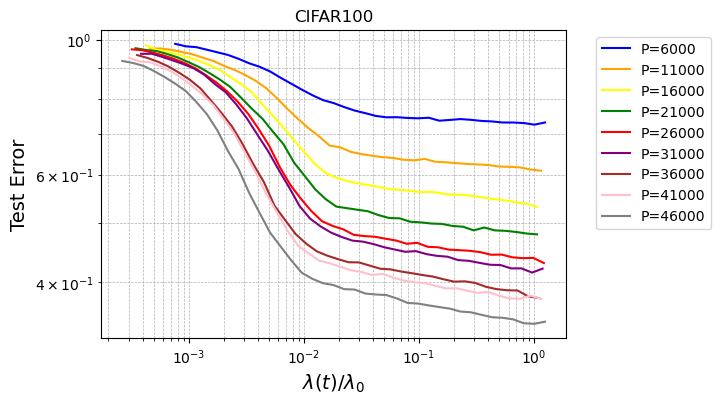

In [332]:
wd=0.0
# Store interpolated results here
mean_curves = {}

# Generate a common log-space grid for interpolation

plt.figure(figsize=(6,4))
l_0_arr = np.zeros(len(P_arr))

for i_P, P in enumerate(P_arr):
    interpolated_val_errors = []
    w_z = 0
    
    for seed in seed_arr:
        logs_saved = np.load(f"../savings/ResNet_{dataset}_P{P}_seed{seed}_WD{wd}.npy", allow_pickle=True).item()
        model_norm = np.array(logs_saved["model_norm"])
        val_error = np.array(logs_saved["val_error"])*0.01
        train_error =np.array(logs_saved["train_error"])*0.01 

        # Interpolation: flat in log-scale, thus interpolate on log(x)
        interp_val_error = np.interp(np.log10(log_x_grid), np.log10(model_norm), val_error, left=np.nan, right=np.nan)
        interpolated_val_errors.append(interp_val_error)

        idx_zero  = np.argmin((val_error)**2)
        where_zero = model_norm[idx_zero]
        w_z += where_zero/(len(seed_arr))

    interpolated_val_errors = np.array(interpolated_val_errors)
    
    # Compute mean ignoring NaNs (important if interpolation goes out of original data range)
    l_0_arr[i_P] = w_z
    mean_val_error = np.nanmean(interpolated_val_errors, axis=0)
    mean_curves[i_P] = mean_val_error

    # Plot the mean curve
    plt.plot(log_x_grid/w_z, mean_val_error,
             color=colorlist[i_P], label=f"P={P}")
    #plt.plot(log_x_grid, log_x_grid**-0.5, "-.",color="black")
    #plt.plot([w_z,w_z],  np.array([0.05,1.]), "--",
    #         color=colorlist[i_P])
    

plt.yscale("log")
plt.xscale("log")
plt.xlabel(r"$\lambda(t)/\lambda_0$", fontsize=14)
plt.ylabel("Test Error", fontsize=14)
plt.legend(bbox_to_anchor=(1.05,1.0))
plt.title(dataset)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()

/tmp/ipykernel_5204/899541357.py:28: RuntimeWarning: Mean of empty slice
  mean_val_error = np.nanmean(interpolated_val_errors, axis=0)


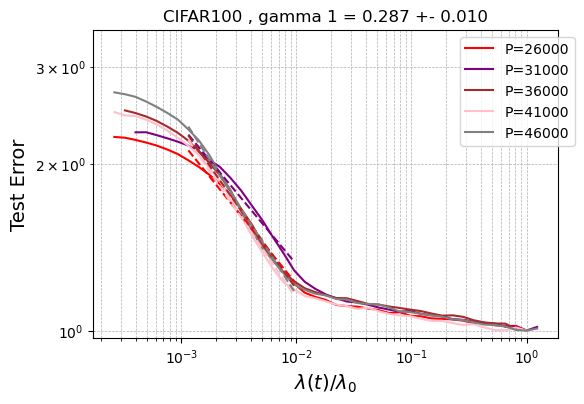

In [338]:
# Store interpolated results here
min_P = 4
P_arr_fit = P_arr[min_P:]

mean_curves = {}

plt.figure(figsize=(6,4))

wd=0.0

for i_P, P in enumerate(P_arr_fit):
    interpolated_val_errors = []
    w_z = 0
    
    for seed in seed_arr:
        logs_saved = np.load(f"../savings/ResNet_{dataset}_P{P}_seed{seed}_WD{wd}.npy", allow_pickle=True).item()
        model_norm = np.array(logs_saved["model_norm"])
        val_error = np.array(logs_saved["val_error"])*0.01
        train_error =np.array(logs_saved["train_error"])*0.01 

        # Interpolation: flat in log-scale, thus interpolate on log(x)
        interp_val_error = np.interp(np.log10(log_x_grid), np.log10(model_norm), val_error, left=np.nan, right=np.nan)
        interpolated_val_errors.append(interp_val_error)


    interpolated_val_errors = np.array(interpolated_val_errors)
    
    mean_val_error = np.nanmean(interpolated_val_errors, axis=0)

    idx = np.nanargmin(mean_val_error)
    # Plot the mean curve
    plt.plot(log_x_grid/log_x_grid[idx], mean_val_error/mean_val_error[idx],
             color=colorlist[i_P+min_P], label=f"P={P}")
    #plt.plot(log_x_grid, log_x_grid**-0.5, "-.",color="black")
    #plt.plot([w_z,w_z],  np.array([0.05,1.]), "--",
    #         color=colorlist[i_P])

    #gamma_1 = 0.23
    #k1 = 0.8
    #plt.plot(log_x_grid/log_x_grid[idx], k1*(log_x_grid/log_x_grid[idx])**-gamma_1, "--",
    #         color="black")

x_left = 1e-3
x_right = 1e-2
gamma_1, k1, err_gamma_1 = fit_phi(log_x_grid, mean_val_error_arr, P_arr_fit, min_P, x_left, x_right)

plt.yscale("log")
plt.xscale("log")
plt.xlabel(r"$\lambda(t)/\lambda_0$", fontsize=14)
plt.ylabel("Test Error", fontsize=14)
plt.legend(bbox_to_anchor=(1.05,1.0))
plt.title("{} , gamma 1 = {:.3f} +- {:.3f}".format(dataset, gamma_1, err_gamma_1))
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.ylim((0.97,3.5))
plt.show()

In [339]:
factor = 1

Fitted power law: k2 = 27.83, gamma2 = 1.17


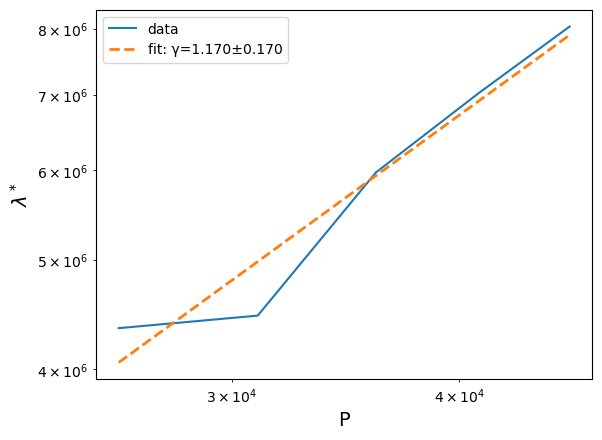

In [340]:
l_power_law = factor*l_0_arr[min_P:]
k2, gamma_2,err_gamma_2 = fit_and_plot_powerlaw(P_arr_fit, l_power_law)
print(f"Fitted power law: k2 = {k2:.4g}, gamma2 = {gamma_2:.4g}")

In [ ]:
'''
l_power_law = factor * l_0_arr

k2, gamma_2 = fit_and_plot_powerlaw_offset(P_arr, l_power_law, C2)
print(f"Offset power law fit: k={k2:.4g}, γ={gamma_2:.4g}, C={C2:.4g}")
'''

In [ ]:
gamma_1 = (gamma_1_a+gamma_1_b)/2
k1 = (k1_a+k1_b)/2
print(gamma_1*gamma_2)

/tmp/ipykernel_5204/1922478856.py:20: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


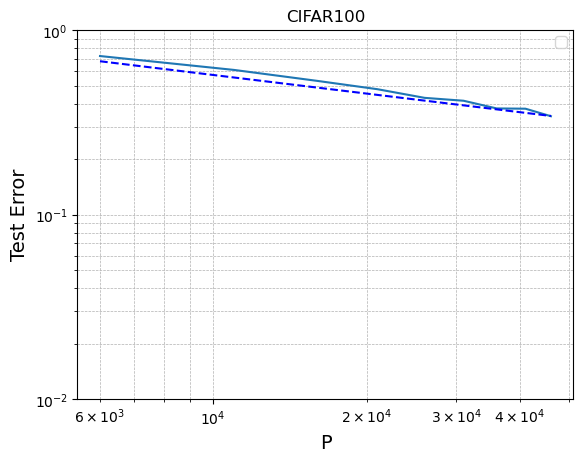

In [341]:
eps_lam_star_P_arr = np.zeros(len(P_arr))

lambda_star_arr = np.zeros(len(P_arr))

for i_P,P in enumerate(P_arr):
     idx = np.nanargmin(mean_val_error_arr[i_P])
     #idx = ((log_x_grid-l_power_law[i_P])**2) 
     eps_lam_star_P_arr[i_P] = mean_val_error_arr[i_P,idx]
     lambda_star_arr[i_P] = log_x_grid[idx]
    
plt.plot(P_arr, eps_lam_star_P_arr)

plt.plot(P_arr, 100*k1*(k2*P_arr**gamma_2)**-gamma_1, "--", color="blue")
#plt.plot(P_arr, 3.6*P_arr**-0.24, "--", color="red")

plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"P", fontsize=14)
plt.ylabel("Test Error", fontsize=14)
plt.legend()
plt.title(dataset)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)

plt.ylim((1e-2,1.01))
plt.show()

In [342]:
name_save = "ResNet_CIFAR100"

to_save["mean_val_error_arr"] = mean_val_error_arr
to_save["eps_lam_star_P_arr"] = eps_lam_star_P_arr
to_save["lambda_star_arr"] = lambda_star_arr
to_save["k1"] = k1
to_save["gamma_1"] = gamma_1
to_save["err_gamma_1"] = err_gamma_1
to_save["k2"] = k2
to_save["gamma_2"] = gamma_2
to_save["err_gamma_2"] = err_gamma_2
to_save["C2"] = C2
to_save["factor"] = factor
to_save["l_0_arr"] = l_0_arr
to_save["min_P"] = min_P


np.save(name_save, to_save)

# ViT new

## MNIST

/tmp/ipykernel_5204/1903524079.py:37: RuntimeWarning: Mean of empty slice
  mean_val_error = np.nanmean(interpolated_val_errors, axis=0)


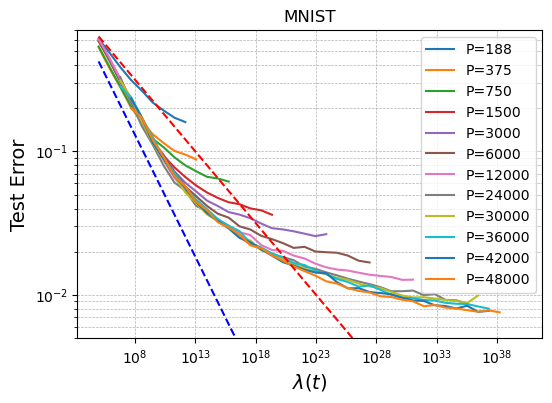

In [366]:

dataset = "MNIST"
P_arr = np.array([188, 375, 750, 1500, 3000, 6000, 12000, 24000 ,30000 ,36000, 42000, 48000])
seed_arr = np.arange(11120,11130)

wd=0.0
colorlist   = np.array(["blue","orange", "yellow","green","red","purple","brown","pink","grey","olive","cyan","goldenrod","palegreen"])

# Store interpolated results here
mean_curves = {}

# Generate a common log-space grid for interpolation
log_x_grid = np.logspace(5, 40, num=40)  # Adjust range and number of points as needed
mean_val_error_arr = np.zeros((len(P_arr), len(log_x_grid)))

to_save = {}
to_save["P_arr"] = P_arr
to_save["seed_arr"] = seed_arr
to_save["log_x_grid"] = log_x_grid

plt.figure(figsize=(6,4))

for i_P,P in enumerate(P_arr):
    interpolated_val_errors = []
    
    for seed in seed_arr:
        logs_saved = np.load(f"../savings/ViT_{dataset}_P{P}_seed{seed}_WD{wd}.npy", allow_pickle=True).item()
        model_norm = np.exp(np.array(logs_saved["model_norm"]).astype(np.double))
        val_error = (np.array(logs_saved["val_error"])*0.01).astype(np.double)

        # Interpolation: flat in log-scale, thus interpolate on log(x)
        interp_val_error = np.interp(np.log10(log_x_grid), np.log10(model_norm), val_error, left=np.nan, right=np.nan)
        interpolated_val_errors.append(interp_val_error)

    interpolated_val_errors = np.array(interpolated_val_errors)
    
    # Compute mean ignoring NaNs (important if interpolation goes out of original data range)
    mean_val_error = np.nanmean(interpolated_val_errors, axis=0)
    mean_curves[P] = mean_val_error
    mean_val_error_arr[i_P] = mean_val_error


    # Plot the mean curve
    plt.plot(log_x_grid, mean_val_error, label=f"P={P}")


gamma_1_a = 0.17
k1_a = 3
plt.plot(log_x_grid, k1_a*log_x_grid**-gamma_1_a, "--", color="blue")
gamma_1_b = 0.1
k1_b = 2.
plt.plot(log_x_grid, k1_b*log_x_grid**-gamma_1_b, "--", color="red")
plt.yscale("log")
plt.xscale("log")
plt.xlabel(r"$\lambda(t)$", fontsize=14)
plt.ylabel("Test Error", fontsize=14)
plt.legend()
plt.title(dataset)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)

plt.ylim((0.005,0.7))
plt.show()


In [367]:
C2 = 1e3

/tmp/ipykernel_5204/1298629554.py:32: RuntimeWarning: Mean of empty slice
  mean_val_error = np.nanmean(interpolated_val_errors, axis=0)


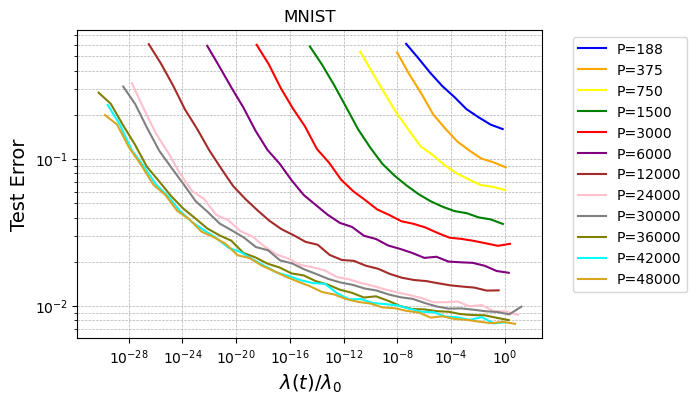

In [372]:
wd=0.0
# Store interpolated results here
mean_curves = {}

# Generate a common log-space grid for interpolation

plt.figure(figsize=(6,4))
l_0_arr = np.zeros(len(P_arr))

for i_P, P in enumerate(P_arr):
    interpolated_val_errors = []
    w_z = 0
    
    for seed in seed_arr:
        logs_saved = np.load(f"../savings/ViT_{dataset}_P{P}_seed{seed}_WD{wd}.npy", allow_pickle=True).item()
        model_norm = np.exp(np.array(logs_saved["model_norm"]).astype(np.double))
        val_error = (np.array(logs_saved["val_error"])*0.01).astype(np.double)
        train_error =(np.array(logs_saved["train_error"])*0.01).astype(np.double) 

        # Interpolation: flat in log-scale, thus interpolate on log(x)
        interp_val_error = np.interp(np.log10(log_x_grid), np.log10(model_norm), val_error, left=np.nan, right=np.nan)
        interpolated_val_errors.append(interp_val_error)

        idx_zero  = np.argmin((val_error)**2)
        where_zero = model_norm[idx_zero]
        w_z += where_zero/(len(seed_arr))

    interpolated_val_errors = np.array(interpolated_val_errors)
    
    # Compute mean ignoring NaNs (important if interpolation goes out of original data range)
    l_0_arr[i_P] = w_z
    mean_val_error = np.nanmean(interpolated_val_errors, axis=0)
    mean_curves[i_P] = mean_val_error

    # Plot the mean curve
    plt.plot(log_x_grid/w_z, mean_val_error,
             color=colorlist[i_P], label=f"P={P}")
    #plt.plot(log_x_grid, log_x_grid**-0.5, "-.",color="black")
    #plt.plot([w_z,w_z],  np.array([0.05,1.]), "--",
    #         color=colorlist[i_P])
    

plt.yscale("log")
plt.xscale("log")
plt.xlabel(r"$\lambda(t)/\lambda_0$", fontsize=14)
plt.ylabel("Test Error", fontsize=14)
plt.legend(bbox_to_anchor=(1.05,1.0))
plt.title(dataset)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()

/tmp/ipykernel_5204/1557866266.py:28: RuntimeWarning: Mean of empty slice
  mean_val_error = np.nanmean(interpolated_val_errors, axis=0)


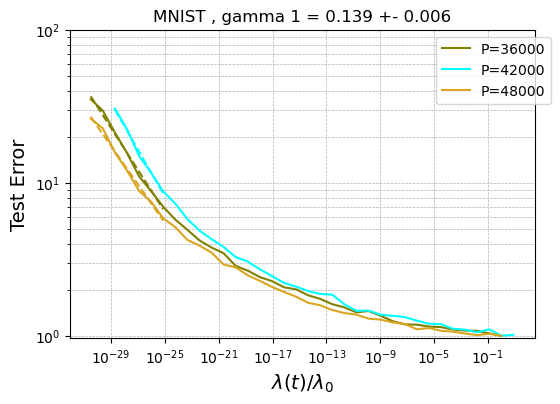

In [373]:
# Store interpolated results here
min_P = 9
P_arr_fit = P_arr[min_P:]

mean_curves = {}

plt.figure(figsize=(6,4))

wd=0.0

for i_P, P in enumerate(P_arr_fit):
    interpolated_val_errors = []
    w_z = 0
    
    for seed in seed_arr:
        logs_saved = np.load(f"../savings/ViT_{dataset}_P{P}_seed{seed}_WD{wd}.npy", allow_pickle=True).item()
        model_norm = np.exp(np.array(logs_saved["model_norm"]).astype(np.double))
        val_error = (np.array(logs_saved["val_error"])*0.01).astype(np.double)
        train_error =(np.array(logs_saved["train_error"])*0.01).astype(np.double) 

        # Interpolation: flat in log-scale, thus interpolate on log(x)
        interp_val_error = np.interp(np.log10(log_x_grid), np.log10(model_norm), val_error, left=np.nan, right=np.nan)
        interpolated_val_errors.append(interp_val_error)


    interpolated_val_errors = np.array(interpolated_val_errors)
    
    mean_val_error = np.nanmean(interpolated_val_errors, axis=0)

    idx = np.nanargmin(mean_val_error)
    # Plot the mean curve
    plt.plot(log_x_grid/log_x_grid[idx], mean_val_error/mean_val_error[idx],
             color=colorlist[i_P+min_P], label=f"P={P}")
    #plt.plot(log_x_grid, log_x_grid**-0.5, "-.",color="black")
    #plt.plot([w_z,w_z],  np.array([0.05,1.]), "--",
    #         color=colorlist[i_P])

    #gamma_1 = 0.23
    #k1 = 0.8
    #plt.plot(log_x_grid/log_x_grid[idx], k1*(log_x_grid/log_x_grid[idx])**-gamma_1, "--",
    #         color="black")

x_left = None
x_right = 1e-25
gamma_1, k1, err_gamma_1 = fit_phi(log_x_grid, mean_val_error_arr, P_arr_fit, min_P, x_left, x_right)

plt.yscale("log")
plt.xscale("log")
plt.xlabel(r"$\lambda(t)/\lambda_0$", fontsize=14)
plt.ylabel("Test Error", fontsize=14)
plt.legend(bbox_to_anchor=(1.05,1.0))
plt.title("{} , gamma 1 = {:.3f} +- {:.3f}".format(dataset, gamma_1, err_gamma_1))
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.ylim((0.97,100.5))
plt.show()

In [374]:
factor = 1

Fitted power law: k2 = 3.025e+21, gamma2 = 3.411


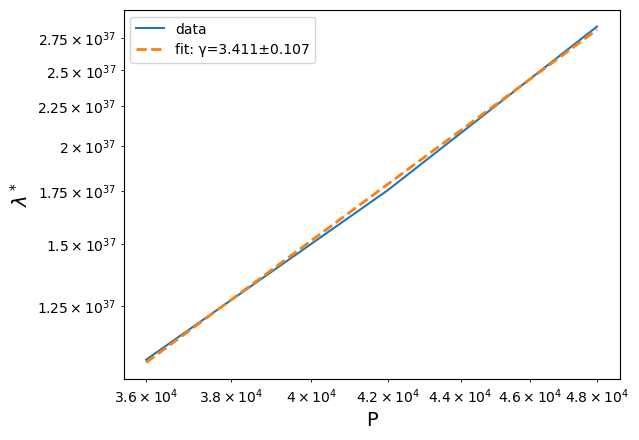

In [375]:
l_power_law = factor*l_0_arr[min_P:]
k2, gamma_2,err_gamma_2 = fit_and_plot_powerlaw(P_arr_fit, l_power_law)
print(f"Fitted power law: k2 = {k2:.4g}, gamma2 = {gamma_2:.4g}")

/tmp/ipykernel_5204/1672640404.py:20: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


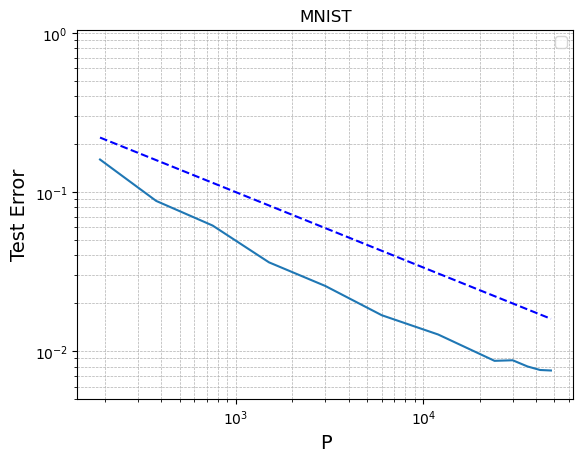

In [376]:
eps_lam_star_P_arr = np.zeros(len(P_arr))

lambda_star_arr = np.zeros(len(P_arr))

for i_P,P in enumerate(P_arr):
     idx = np.nanargmin(mean_val_error_arr[i_P])
     #idx = ((log_x_grid-l_power_law[i_P])**2) 
     eps_lam_star_P_arr[i_P] = mean_val_error_arr[i_P,idx]
     lambda_star_arr[i_P] = log_x_grid[idx]

plt.plot(P_arr, eps_lam_star_P_arr)

plt.plot(P_arr,  1000000*k1*(k2*P_arr**gamma_2)**-gamma_1, "--", color="blue")
#plt.plot(P_arr, 3.6*P_arr**-0.24, "--", color="red")

plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"P", fontsize=14)
plt.ylabel("Test Error", fontsize=14)
plt.legend()
plt.title(dataset)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.ylim((5e-3,1.05))
plt.show()

In [377]:
name_save = "ViT_MNIST"


to_save["mean_val_error_arr"] = mean_val_error_arr
to_save["eps_lam_star_P_arr"] = eps_lam_star_P_arr
to_save["lambda_star_arr"] = lambda_star_arr
to_save["k1"] = k1
to_save["gamma_1"] = gamma_1
to_save["err_gamma_1"] = err_gamma_1
to_save["k2"] = k2
to_save["gamma_2"] = gamma_2
to_save["err_gamma_2"] = err_gamma_2
to_save["C2"] = C2
to_save["factor"] = factor
to_save["l_0_arr"] = l_0_arr
to_save["min_P"] = min_P

np.save(name_save, to_save)

## CIFAR10

/tmp/ipykernel_5204/4186038516.py:37: RuntimeWarning: Mean of empty slice
  mean_val_error = np.nanmean(interpolated_val_errors, axis=0)


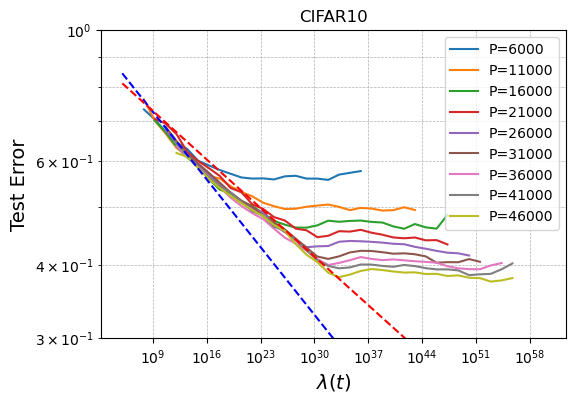

In [399]:
dataset = "CIFAR10"
P_arr = np.arange(6000, 46001, 5000)
seed_arr = np.arange(11120,11128)

wd=0.0
colorlist   = np.array(["blue","orange", "yellow","green","red","purple","brown","pink","grey","olive","cyan","goldenrod","palegreen"])

# Store interpolated results here
mean_curves = {}

# Generate a common log-space grid for interpolation
log_x_grid = np.logspace(5, 60, num=40)  # Adjust range and number of points as needed
mean_val_error_arr = np.zeros((len(P_arr), len(log_x_grid)))

to_save = {}
to_save["P_arr"] = P_arr
to_save["seed_arr"] = seed_arr
to_save["log_x_grid"] = log_x_grid

plt.figure(figsize=(6,4))

for i_P,P in enumerate(P_arr):
    interpolated_val_errors = []
    
    for seed in seed_arr:
        logs_saved = np.load(f"../savings/ViT_{dataset}_P{P}_seed{seed}_WD{wd}.npy", allow_pickle=True).item()
        model_norm = np.exp(np.array(logs_saved["model_norm"]).astype(np.double))
        val_error = (np.array(logs_saved["val_error"])*0.01).astype(np.double)

        # Interpolation: flat in log-scale, thus interpolate on log(x)
        interp_val_error = np.interp(np.log10(log_x_grid), np.log10(model_norm), val_error, left=np.nan, right=np.nan)
        interpolated_val_errors.append(interp_val_error)

    interpolated_val_errors = np.array(interpolated_val_errors)
    
    # Compute mean ignoring NaNs (important if interpolation goes out of original data range)
    mean_val_error = np.nanmean(interpolated_val_errors, axis=0)
    mean_curves[P] = mean_val_error
    mean_val_error_arr[i_P] = mean_val_error


    # Plot the mean curve
    plt.plot(log_x_grid, mean_val_error, label=f"P={P}")

gamma_1_a = (1/61)
k1_a = 1.02
plt.plot(log_x_grid, k1_a*log_x_grid**-gamma_1_a, "--", color="blue")
gamma_1_b = (1/85)
k1_b = 0.93
plt.plot(log_x_grid, k1_b*log_x_grid**-gamma_1_b, "--", color="red")

plt.yscale("log")
plt.xscale("log")
plt.xlabel(r"$\lambda(t)$", fontsize=14)
plt.ylabel("Test Error", fontsize=14)
plt.legend()
plt.title(dataset)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)

plt.ylim((0.3,1.))
plt.show()

In [400]:
C2 = 1e4

/tmp/ipykernel_5204/346930388.py:32: RuntimeWarning: Mean of empty slice
  mean_val_error = np.nanmean(interpolated_val_errors, axis=0)


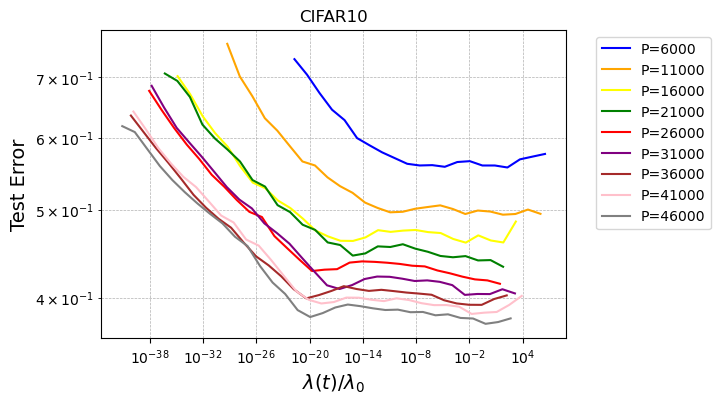

In [401]:
wd=0.0
# Store interpolated results here
mean_curves = {}

# Generate a common log-space grid for interpolation

plt.figure(figsize=(6,4))
l_0_arr = np.zeros(len(P_arr))

for i_P, P in enumerate(P_arr):
    interpolated_val_errors = []
    w_z = 0
    
    for seed in seed_arr:
        logs_saved = np.load(f"../savings/ViT_{dataset}_P{P}_seed{seed}_WD{wd}.npy", allow_pickle=True).item()
        model_norm = np.exp(np.array(logs_saved["model_norm"]).astype(np.double))
        val_error = (np.array(logs_saved["val_error"])*0.01).astype(np.double)
        train_error =(np.array(logs_saved["train_error"])*0.01).astype(np.double) 

        # Interpolation: flat in log-scale, thus interpolate on log(x)
        interp_val_error = np.interp(np.log10(log_x_grid), np.log10(model_norm), val_error, left=np.nan, right=np.nan)
        interpolated_val_errors.append(interp_val_error)

        idx_zero  = np.argmin((val_error)**2)
        where_zero = model_norm[idx_zero]
        w_z += where_zero/(len(seed_arr)*len(P_arr))

    interpolated_val_errors = np.array(interpolated_val_errors)
    
    # Compute mean ignoring NaNs (important if interpolation goes out of original data range)
    l_0_arr[i_P] = w_z
    mean_val_error = np.nanmean(interpolated_val_errors, axis=0)
    mean_curves[i_P] = mean_val_error

    # Plot the mean curve
    plt.plot(log_x_grid/w_z, mean_val_error,
             color=colorlist[i_P], label=f"P={P}")
    #plt.plot(log_x_grid, log_x_grid**-0.5, "-.",color="black")
    #plt.plot([w_z,w_z],  np.array([0.05,1.]), "--",
    #         color=colorlist[i_P])
    

plt.yscale("log")
plt.xscale("log")
plt.xlabel(r"$\lambda(t)/\lambda_0$", fontsize=14)
plt.ylabel("Test Error", fontsize=14)
plt.legend(bbox_to_anchor=(1.05,1.0))
plt.title(dataset)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()

/tmp/ipykernel_5204/4167414849.py:28: RuntimeWarning: Mean of empty slice
  mean_val_error = np.nanmean(interpolated_val_errors, axis=0)


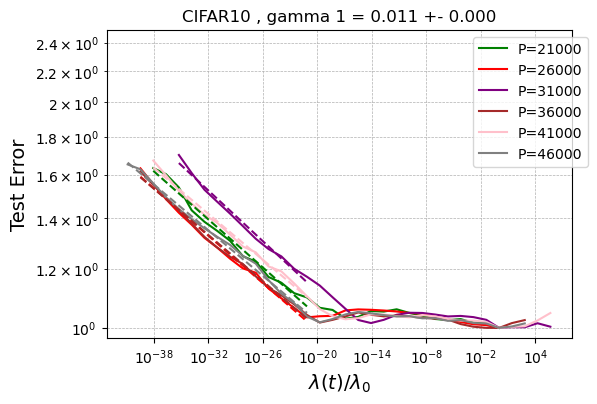

In [402]:
# Store interpolated results here
min_P = 3
P_arr_fit = P_arr[min_P:]

mean_curves = {}

plt.figure(figsize=(6,4))

wd=0.0

for i_P, P in enumerate(P_arr_fit):
    interpolated_val_errors = []
    w_z = 0
    
    for seed in seed_arr:
        logs_saved = np.load(f"../savings/ViT_{dataset}_P{P}_seed{seed}_WD{wd}.npy", allow_pickle=True).item()
        model_norm = np.exp(np.array(logs_saved["model_norm"]).astype(np.double))
        val_error = (np.array(logs_saved["val_error"])*0.01).astype(np.double)
        train_error =(np.array(logs_saved["train_error"])*0.01).astype(np.double) 

        # Interpolation: flat in log-scale, thus interpolate on log(x)
        interp_val_error = np.interp(np.log10(log_x_grid), np.log10(model_norm), val_error, left=np.nan, right=np.nan)
        interpolated_val_errors.append(interp_val_error)


    interpolated_val_errors = np.array(interpolated_val_errors)
    
    mean_val_error = np.nanmean(interpolated_val_errors, axis=0)

    idx = np.nanargmin(mean_val_error)
    # Plot the mean curve
    plt.plot(log_x_grid/log_x_grid[idx], mean_val_error/mean_val_error[idx],
             color=colorlist[i_P+min_P], label=f"P={P}")
    #plt.plot(log_x_grid, log_x_grid**-0.5, "-.",color="black")
    #plt.plot([w_z,w_z],  np.array([0.05,1.]), "--",
    #         color=colorlist[i_P])

    #gamma_1 = 0.23
    #k1 = 0.8
    #plt.plot(log_x_grid/log_x_grid[idx], k1*(log_x_grid/log_x_grid[idx])**-gamma_1, "--",
    #         color="black")

x_left = None
x_right = 1e-20
gamma_1, k1, err_gamma_1 = fit_phi(log_x_grid, mean_val_error_arr, P_arr_fit, min_P, x_left, x_right)

plt.yscale("log")
plt.xscale("log")
plt.xlabel(r"$\lambda(t)/\lambda_0$", fontsize=14)
plt.ylabel("Test Error", fontsize=14)
plt.legend(bbox_to_anchor=(1.05,1.0))
plt.title("{} , gamma 1 = {:.3f} +- {:.3f}".format(dataset, gamma_1, err_gamma_1))
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.ylim((0.97,2.5))
plt.show()

In [390]:
factor = 1.

Fitted power law: k2 = 1.67e-49, gamma2 = 21.9


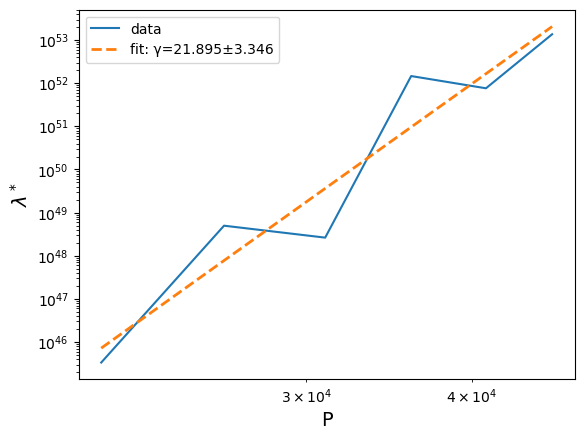

In [404]:
l_power_law = factor*l_0_arr[min_P:]
k2, gamma_2, err_gamma_2 = fit_and_plot_powerlaw(P_arr_fit, l_power_law)
print(f"Fitted power law: k2 = {k2:.4g}, gamma2 = {gamma_2:.4g}")

In [10]:
'''
l_power_law = factor * l_0_arr

k2, gamma_2 = fit_and_plot_powerlaw_offset(P_arr, l_power_law, C2)
print(f"Offset power law fit: k={k2:.4g}, γ={gamma_2:.4g}, C={C2:.4g}")
'''

'\nl_power_law = factor * l_0_arr\n\nk2, gamma_2 = fit_and_plot_powerlaw_offset(P_arr, l_power_law, C2)\nprint(f"Offset power law fit: k={k2:.4g}, γ={gamma_2:.4g}, C={C2:.4g}")\n'

[0.28094247 0.24429699 0.22407624 0.21045729 0.20034402 0.19238111
 0.18586094 0.18037005 0.17564719]


/tmp/ipykernel_5204/1554735193.py:21: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


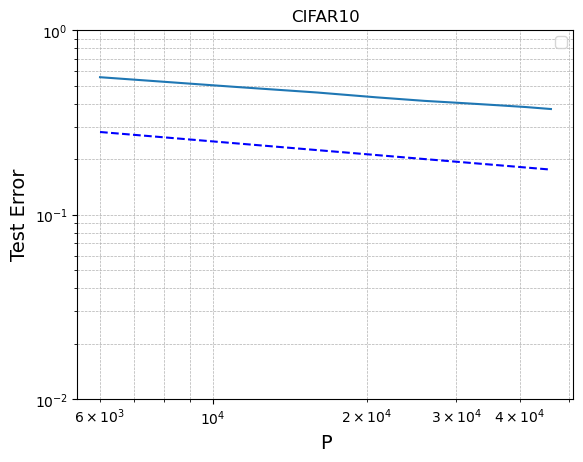

In [405]:
eps_lam_star_P_arr = np.zeros(len(P_arr))

lambda_star_arr = np.zeros(len(P_arr))

for i_P,P in enumerate(P_arr):
     idx = np.nanargmin(mean_val_error_arr[i_P])
     #idx = ((log_x_grid-l_power_law[i_P])**2) 
     eps_lam_star_P_arr[i_P] = mean_val_error_arr[i_P,idx]
     lambda_star_arr[i_P] = log_x_grid[idx]
    
plt.plot(P_arr, eps_lam_star_P_arr)

print(k1*(k2*P_arr**gamma_2-C2)**-gamma_1)
plt.plot(P_arr, k1*(k2*P_arr**gamma_2)**-gamma_1, "--", color="blue")
#plt.plot(P_arr, 3.6*P_arr**-0.24, "--", color="red")

plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"P", fontsize=14)
plt.ylabel("Test Error", fontsize=14)
plt.legend()
plt.title(dataset)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)

plt.ylim((1e-2,1.01))
plt.show()

In [406]:
name_save = "ViT_CIFAR10"

to_save["mean_val_error_arr"] = mean_val_error_arr
to_save["eps_lam_star_P_arr"] = eps_lam_star_P_arr
to_save["lambda_star_arr"] = lambda_star_arr
to_save["k1"] = k1
to_save["gamma_1"] = gamma_1
to_save["err_gamma_1"] = err_gamma_1
to_save["k2"] = k2
to_save["gamma_2"] = gamma_2
to_save["err_gamma_2"] = err_gamma_2
to_save["C2"] = C2
to_save["factor"] = factor
to_save["l_0_arr"] = l_0_arr
to_save["min_P"] = min_P

np.save(name_save, to_save)

## Cifar100

/tmp/ipykernel_32690/3214978902.py:37: RuntimeWarning: Mean of empty slice
  mean_val_error = np.nanmean(interpolated_val_errors, axis=0)


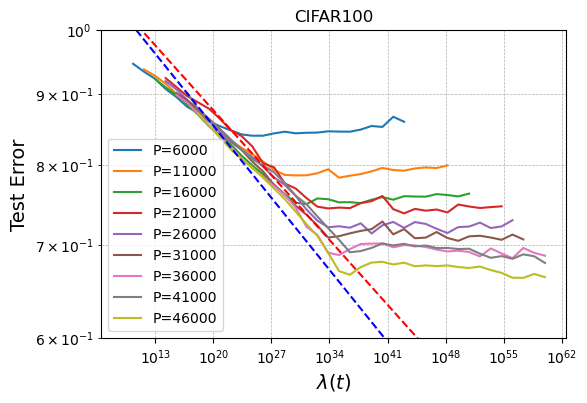

In [14]:
dataset = "CIFAR100"
P_arr = np.arange(6000, 46001, 5000)
seed_arr = np.arange(11120,11125)

wd=0.0
colorlist   = np.array(["blue","orange", "yellow","green","red","purple","brown","pink","grey","olive","cyan","goldenrod","palegreen"])

# Store interpolated results here
mean_curves = {}

# Generate a common log-space grid for interpolation
log_x_grid = np.logspace(9, 60, num=40)  # Adjust range and number of points as needed
mean_val_error_arr = np.zeros((len(P_arr), len(log_x_grid)))

to_save = {}
to_save["P_arr"] = P_arr
to_save["seed_arr"] = seed_arr
to_save["log_x_grid"] = log_x_grid

plt.figure(figsize=(6,4))

for i_P,P in enumerate(P_arr):
    interpolated_val_errors = []
    
    for seed in seed_arr:
        logs_saved = np.load(f"../savings/ViT_{dataset}_P{P}_seed{seed}_WD{wd}.npy", allow_pickle=True).item()
        model_norm = np.exp(np.array(logs_saved["model_norm"]).astype(np.double))
        val_error = (np.array(logs_saved["val_error"])*0.01).astype(np.double)

        # Interpolation: flat in log-scale, thus interpolate on log(x)
        interp_val_error = np.interp(np.log10(log_x_grid), np.log10(model_norm), val_error, left=np.nan, right=np.nan)
        interpolated_val_errors.append(interp_val_error)

    interpolated_val_errors = np.array(interpolated_val_errors)
    
    # Compute mean ignoring NaNs (important if interpolation goes out of original data range)
    mean_val_error = np.nanmean(interpolated_val_errors, axis=0)
    mean_curves[P] = mean_val_error
    mean_val_error_arr[i_P] = mean_val_error


    # Plot the mean curve
    plt.plot(log_x_grid, mean_val_error, label=f"P={P}")


gamma_1_a = (1/135)
k1_a = 1.2
plt.plot(log_x_grid, k1_a*log_x_grid**-gamma_1_a, "--", color="blue")
gamma_1_b = (1/150)
k1_b = 1.19
plt.plot(log_x_grid, k1_b*log_x_grid**-gamma_1_b, "--", color="red")

plt.yscale("log")
plt.xscale("log")
plt.xlabel(r"$\lambda(t)$", fontsize=14)
plt.ylabel("Test Error", fontsize=14)
plt.legend()
plt.title(dataset)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)

plt.ylim((0.6,1.))
plt.show()

In [15]:
C2 = 1e20

/tmp/ipykernel_32690/1298629554.py:32: RuntimeWarning: Mean of empty slice
  mean_val_error = np.nanmean(interpolated_val_errors, axis=0)


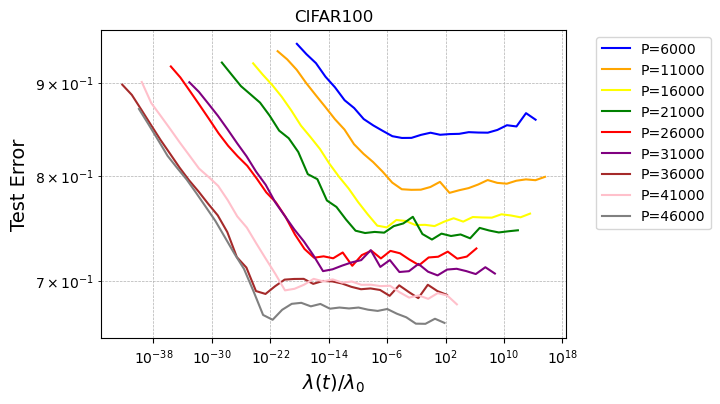

In [16]:
wd=0.0
# Store interpolated results here
mean_curves = {}

# Generate a common log-space grid for interpolation

plt.figure(figsize=(6,4))
l_0_arr = np.zeros(len(P_arr))

for i_P, P in enumerate(P_arr):
    interpolated_val_errors = []
    w_z = 0
    
    for seed in seed_arr:
        logs_saved = np.load(f"../savings/ViT_{dataset}_P{P}_seed{seed}_WD{wd}.npy", allow_pickle=True).item()
        model_norm = np.exp(np.array(logs_saved["model_norm"]).astype(np.double))
        val_error = (np.array(logs_saved["val_error"])*0.01).astype(np.double)
        train_error =(np.array(logs_saved["train_error"])*0.01).astype(np.double) 

        # Interpolation: flat in log-scale, thus interpolate on log(x)
        interp_val_error = np.interp(np.log10(log_x_grid), np.log10(model_norm), val_error, left=np.nan, right=np.nan)
        interpolated_val_errors.append(interp_val_error)

        idx_zero  = np.argmin((val_error)**2)
        where_zero = model_norm[idx_zero]
        w_z += where_zero/(len(seed_arr))

    interpolated_val_errors = np.array(interpolated_val_errors)
    
    # Compute mean ignoring NaNs (important if interpolation goes out of original data range)
    l_0_arr[i_P] = w_z
    mean_val_error = np.nanmean(interpolated_val_errors, axis=0)
    mean_curves[i_P] = mean_val_error

    # Plot the mean curve
    plt.plot(log_x_grid/w_z, mean_val_error,
             color=colorlist[i_P], label=f"P={P}")
    #plt.plot(log_x_grid, log_x_grid**-0.5, "-.",color="black")
    #plt.plot([w_z,w_z],  np.array([0.05,1.]), "--",
    #         color=colorlist[i_P])
    

plt.yscale("log")
plt.xscale("log")
plt.xlabel(r"$\lambda(t)/\lambda_0$", fontsize=14)
plt.ylabel("Test Error", fontsize=14)
plt.legend(bbox_to_anchor=(1.05,1.0))
plt.title(dataset)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()

/tmp/ipykernel_32690/3081834397.py:28: RuntimeWarning: Mean of empty slice
  mean_val_error = np.nanmean(interpolated_val_errors, axis=0)


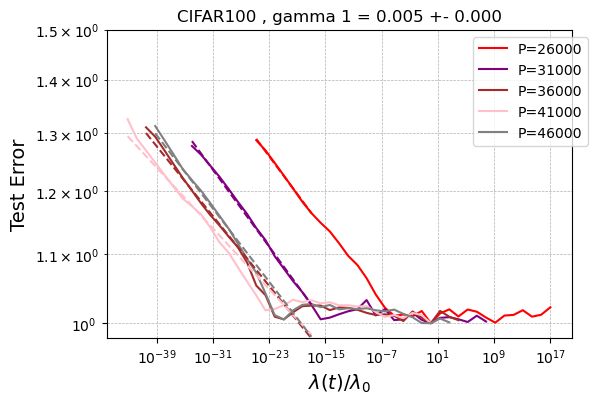

In [26]:
# Store interpolated results here
min_P = 4
P_arr_fit = P_arr[min_P:]

mean_curves = {}

plt.figure(figsize=(6,4))

wd=0.0

for i_P, P in enumerate(P_arr_fit):
    interpolated_val_errors = []
    w_z = 0
    
    for seed in seed_arr:
        logs_saved = np.load(f"../savings/ViT_{dataset}_P{P}_seed{seed}_WD{wd}.npy", allow_pickle=True).item()
        model_norm = np.exp(np.array(logs_saved["model_norm"]).astype(np.double))
        val_error = (np.array(logs_saved["val_error"])*0.01).astype(np.double)
        train_error =(np.array(logs_saved["train_error"])*0.01).astype(np.double) 

        # Interpolation: flat in log-scale, thus interpolate on log(x)
        interp_val_error = np.interp(np.log10(log_x_grid), np.log10(model_norm), val_error, left=np.nan, right=np.nan)
        interpolated_val_errors.append(interp_val_error)


    interpolated_val_errors = np.array(interpolated_val_errors)
    
    mean_val_error = np.nanmean(interpolated_val_errors, axis=0)

    idx = np.nanargmin(mean_val_error)
    # Plot the mean curve
    plt.plot(log_x_grid/log_x_grid[idx], mean_val_error/mean_val_error[idx],
             color=colorlist[i_P+min_P], label=f"P={P}")
    #plt.plot(log_x_grid, log_x_grid**-0.5, "-.",color="black")
    #plt.plot([w_z,w_z],  np.array([0.05,1.]), "--",
    #         color=colorlist[i_P])

    #gamma_1 = 0.23
    #k1 = 0.8
    #plt.plot(log_x_grid/log_x_grid[idx], k1*(log_x_grid/log_x_grid[idx])**-gamma_1, "--",
    #         color="black")

x_left = None
x_right = 1e-16
gamma_1, k1, err_gamma_1 = fit_phi(log_x_grid, mean_val_error_arr, P_arr_fit, min_P, x_left, x_right)

plt.yscale("log")
plt.xscale("log")
plt.xlabel(r"$\lambda(t)/\lambda_0$", fontsize=14)
plt.ylabel("Test Error", fontsize=14)
plt.legend(bbox_to_anchor=(1.05,1.0))
plt.title("{} , gamma 1 = {:.3f} +- {:.3f}".format(dataset, gamma_1, err_gamma_1))
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.ylim((0.98,1.5))
plt.show()

In [24]:
factor = 1

Fitted power law: k2 = 4.629e-127, gamma2 = 39.69


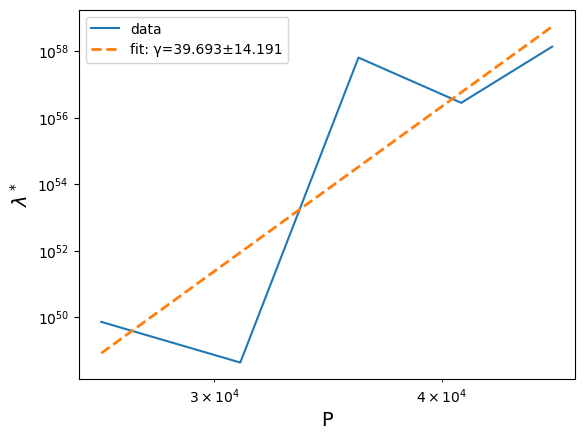

In [27]:
l_power_law = factor*l_0_arr[min_P:]
k2, gamma_2, err_gamma_2 = fit_and_plot_powerlaw(P_arr_fit, l_power_law)
print(f"Fitted power law: k2 = {k2:.4g}, gamma2 = {gamma_2:.4g}")

[0.62247539 0.54733152 0.50549017 0.47714123 0.45599548 0.43928628
 0.42556352 0.41397738 0.40398941]


/tmp/ipykernel_32690/2479446381.py:21: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


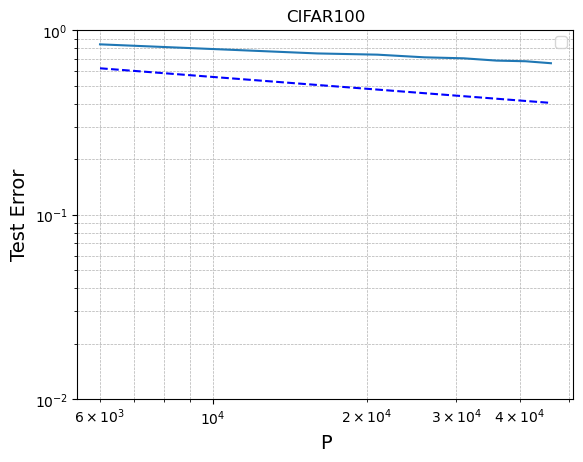

In [28]:
eps_lam_star_P_arr = np.zeros(len(P_arr))

lambda_star_arr = np.zeros(len(P_arr))

for i_P,P in enumerate(P_arr):
     idx = np.nanargmin(mean_val_error_arr[i_P])
     #idx = ((log_x_grid-l_power_law[i_P])**2) 
     eps_lam_star_P_arr[i_P] = mean_val_error_arr[i_P,idx]
     lambda_star_arr[i_P] = log_x_grid[idx]
    
plt.plot(P_arr, eps_lam_star_P_arr)

print(k1*(k2*P_arr**gamma_2-C2)**-gamma_1)
plt.plot(P_arr, k1*(k2*P_arr**gamma_2-C2)**-gamma_1, "--", color="blue")
#plt.plot(P_arr, 3.6*P_arr**-0.24, "--", color="red")

plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"P", fontsize=14)
plt.ylabel("Test Error", fontsize=14)
plt.legend()
plt.title(dataset)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)

plt.ylim((1e-2,1.01))
plt.show()

In [29]:
name_save = "ViT_CIFAR100"

to_save["mean_val_error_arr"] = mean_val_error_arr
to_save["eps_lam_star_P_arr"] = eps_lam_star_P_arr
to_save["lambda_star_arr"] = lambda_star_arr
to_save["k1"] = k1
to_save["gamma_1"] = gamma_1
to_save["err_gamma_1"] = err_gamma_1
to_save["k2"] = k2
to_save["gamma_2"] = gamma_2
to_save["err_gamma_2"] = err_gamma_2
to_save["C2"] = C2
to_save["factor"] = factor
to_save["l_0_arr"] = l_0_arr
to_save["min_P"] = min_P

np.save(name_save, to_save)